In [1]:
import qiskit
qiskit.__version__

'0.16.1'

In [2]:
# Import required package
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import qrng
from math import pi
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_histogram

In [3]:
#Initialize HyperParameter
Ngen = 200   #define Ngen  
Nvar = 10     #define Nvar
Nbit = 10     #define the variable bits

theta_1 = 0.08 *pi
theta_2 = 0.001 *pi

# api token from IBMQ experience
apitoken ='e26cab383f69b81aaf36106b0620f3e994afd5ef57bb861bc714b41a91dabb3c08dcc5f5f45fa395a490d1bbf0490a8b1e7caeeaa560546833ca8149d4375ef3'

In [4]:
# Create QuantumCircuit List = sol_list
# return a qc_list represent the solution value [x1, x2, x3, ...]
def God_init():
    '''
    This function initialize the quantum circuit list with Nvar.
    Create QuantumCircuit List = sol_list
    return a qc_list represent the solution value [x1, x2, x3, ...]
    '''
    qc_list = []

    for var in range(Nvar):
        qc = QuantumCircuit(Nbit, Nbit) # Circuit with Nbit qubits and Nbit classical bits
        qr = QuantumRegister(Nbit, 'q')
        cr = ClassicalRegister(Nbit, 'c')
        qc = QuantumCircuit(qr, cr)
        qc.h(qr[0:Nbit])
        qc_list.append(qc)
    return qc_list # return a solution with Nvar

In [5]:
# sol_measure function：Measure a Q state solution to classical bits
def sol_measure(Qsol_list):
    '''
    This function will measure the quantum solution list and return the classical solution list
    '''
    # Use simulator to measure one solution
    Csol_list = []
    Qstate_list = []
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend

    for qc in Qsol_list:
        qc_copy = qc.copy()
        for bit in range(Nbit):
            qc_copy.measure(bit, bit)
        result = execute(qc_copy, simulator).result() # defaul shot number
        result_dict = result.to_dict()
        Qstate_list.append(result_dict['results'][0]['data']['counts'])
    for var in Qstate_list:
        Keymax = max(var, key=var.get) 
        Csol_list.append(int(Keymax, 16))
    return Csol_list
# init_sol_list = sol_measure(God_list)
# init_sol_list

In [6]:
def var_measure(qc):
    '''
    Measure a quantum state var to classical bits and return its demical number.
    '''
    # Use simulator to measure one solution
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend
    qc_copy = qc.copy()
    for bit in range(Nbit):
        qc_copy.measure(bit, bit)
    result = execute(qc_copy, simulator).result() # defaul shot number
    result_dict = result.to_dict()
    # print(result_dict)
    var_dict = result_dict['results'][0]['data']['counts']
    Keymax = max(var_dict, key=var_dict.get) 
    return int(Keymax, 16)

In [7]:
def FIT_cal(XX):
    '''
    This function define the OBJ function and return the fitness value.
    In this example we use the square sum of each variable.
    '''
    SUM = 0
    for var in range(Nvar):
        SUM += XX[var] * XX[var]
    return SUM

In [8]:
def int_to_bin(var):
    '''
    Define a function to convert int to binary number's string.
    '''
    return format(var, f'0{Nbit}b')
# int_to_bin(12)

In [9]:
def get_Qrnd():
    '''
    Function to get random number from a Qubit in quantum computer.
    # Inorder to get real random number.
    '''
    # IBMQ.save_account(apitoken)
    # provider = IBMQ.load_account()
    # qrng.set_provider_as_IBMQ(apitoken) #the IBMQ API token from your dashboard
    qrng.set_backend() #connect to the k qubit by quantum computer
    rnd = qrng.get_random_float(0,1) #generate a random N bit float between 0 to 1
    return rnd
# rnd = get_Qrnd()
# rnd

In [10]:
def get_bin_sol(sol_list):
    '''
    Define a function to convert a list of decimal solution to binary variable in string type.
    '''
    bin_list = []
    for var in sol_list:
        bin_list.append(int_to_bin(var))
    return bin_list

In [11]:
def get_ab_list(God_list):
    '''
    This function will return a list with [ai, bi] state in quantum solution list.
    '''
    backend = Aer.get_backend('statevector_simulator') 
    ab_list = []
    for var in range(Nvar):
        ab_var = []
        for bit in range(Nbit):
            # Create a deep copy of var_i's quantum circuit.
            qc_tmp = God_list[var].copy()
            # Measure from q_0 to q_Nbit
            collapse_bit = [i for i in range(Nbit) if i != bit]
            qc_tmp.measure(collapse_bit, collapse_bit)
            out_state = execute(qc_tmp,backend).result().get_statevector()
            # ab_bit = out_state[out_state>0].tolist()
            out_state_complex = out_state.tolist()
            out_state_real = [out_state_complex[i].real for i in range(len(out_state_complex))]
            ab_bit = [state for state in out_state_real if state != float(0)]
            # print(ab_bit) # if need to check the amplitude
            if len(ab_bit) < 2:
                print("\n +-1 in the state_list!!")
                for i in range(len(out_state_real)):
                    if (out_state_real[i] != float(0)):
                        if ((int(int_to_bin(i)[Nbit - 1 - bit]) == 1)):
                            ab_bit = [0, 1]
                        elif (int(int_to_bin(i)[Nbit - 1 - bit]) == 0):
                            ab_bit = [1, 0]
            ab_var.append(ab_bit)
        ab_list.append(ab_var)
    return ab_list
# get_ab_list(God_list)


In [12]:
def GA_Init():
    Random_Qlist = God_init()
    sol_list = []
    for var in range(Nvar):
        variable = (var_measure(Random_Qlist[var]))
        sol_list.append(variable)
    return sol_list
sol_test = GA_Init()
sol_test

[675, 462, 317, 473, 33, 330, 297, 458, 199, 544]

In [13]:
def best_dict_init():
    '''
    Use best_dict to storage the gbest_fitness, gbest_list, pbest_fitness, pbest_list
    '''
    best_dict = {
        "gbest_fitness": 0,
        "gbest_sol": [0 for i in range(Nvar)],
    }
    return best_dict
best_dict = best_dict_init()
best_dict

{'gbest_fitness': 0, 'gbest_sol': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [14]:
def GA_update(sol_list, sol_fitness):
    '''
    This function update the gbest and pbest for "SOLUTION_i" recorded in best_dict.
    '''
    global best_dict
    global God_list
    
    curr_bin_sol = get_bin_sol(sol_list)
    # if curr_sol is better(in this case: smaller)

    if sol_fitness >= best_dict["gbest_fitness"]:
        Qgbest_ab = get_ab_list(God_list)
        print("Get better Gbest!\n")

        # get the binary sol_list to compare
        gbest_bin_sol = get_bin_sol(best_dict["gbest_sol"])

        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取
                a = Qgbest_ab[var][Nbit - 1 - bit][0]
                b = Qgbest_ab[var][Nbit - 1 - bit][1]

                if (int(gbest_bin_sol[var][bit]) == 0 and int(curr_bin_sol[var][bit]) == 0):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[var].ry((-2)*delta_theta, Nbit - 1 - bit)

                    elif (a*b).real < 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(gbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b) > 0:
                        God_list[var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b) < 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a == 0 or b == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(gbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 1)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(gbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 1)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
        # update the best_dict[gbest]
        best_dict["gbest_fitness"] = sol_fitness
        best_dict["gbest_sol"] = sol_list
    
    # if sol_fitness worse than best_dict["gbest_fitness"]
    elif sol_fitness < best_dict["gbest_fitness"]:
        Qgbest_ab = get_ab_list(God_list)

        # get the binary sol_list to compare
        gbest_bin_sol = get_bin_sol(best_dict["gbest_sol"])
        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取
                a = Qgbest_ab[var][Nbit - 1 - bit][0]
                b = Qgbest_ab[var][Nbit - 1 - bit][1]
                if (int(gbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)

                if int(gbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.08 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(gbest_bin_sol[var][bit]) == 0 and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a == 0 or b == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(gbest_bin_sol[var][bit]) == 1 and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[var].ry(2*delta_theta, Nbit - 1 - bit)

    return God_list

In [18]:
# main function
God_list = God_init()
best_dict = best_dict_init()
sol_list = GA_Init()
sol_fitness = FIT_cal(sol_list)
print(f"Initialize sol:", sol_list)
print("sol_fitness: ", sol_fitness)
GA_update(sol_list, sol_fitness)
gen_info = ["Init"]
fitness_info = [sol_fitness]

for gen in range(Ngen):
    print(f'----- Generation_{gen} -----')
    sol_list = sol_measure(God_list)
    sol_fitness = FIT_cal(sol_list)
    print('sol_fitness: {}'.format(sol_fitness))
    print('sol_list: ',sol_list)
    GA_update(sol_list, sol_fitness)
    fitness_info.append(best_dict['gbest_fitness'])
    gen_info.append(f'{gen}')
        
    print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
    print('Global best solution: {}'.format(best_dict['gbest_sol']))

    

Initialize sol: [315, 263, 654, 501, 749, 461, 809, 115, 478, 286]
sol_fitness:  2598619
Get better Gbest!

----- Generation_0 -----
sol_fitness: 1862241
sol_list:  [462, 18, 302, 345, 44, 276, 473, 839, 359, 551]
Global best fitness: 2598619
Global best solution: [315, 263, 654, 501, 749, 461, 809, 115, 478, 286]
----- Generation_1 -----
sol_fitness: 3354480
sol_list:  [231, 464, 891, 447, 809, 241, 500, 869, 33, 611]
Get better Gbest!

Global best fitness: 3354480
Global best solution: [231, 464, 891, 447, 809, 241, 500, 869, 33, 611]
----- Generation_2 -----
sol_fitness: 3764045
sol_list:  [1006, 466, 305, 478, 477, 374, 476, 799, 309, 941]
Get better Gbest!

Global best fitness: 3764045
Global best solution: [1006, 466, 305, 478, 477, 374, 476, 799, 309, 941]
----- Generation_3 -----
sol_fitness: 3014024
sol_list:  [252, 283, 487, 511, 481, 895, 465, 884, 107, 575]
Global best fitness: 3764045
Global best solution: [1006, 466, 305, 478, 477, 374, 476, 799, 309, 941]
----- Generatio

In [19]:
# plot the fitness 
info_dict = {"Gen_info": gen_info,
             "fitness_info": fitness_info}
info_df = pd.DataFrame(info_dict)
info_df.head()

,Gen_info,fitness_info
0,Init,2598619
1,0,2598619
2,1,3354480
3,2,3764045
4,3,3764045


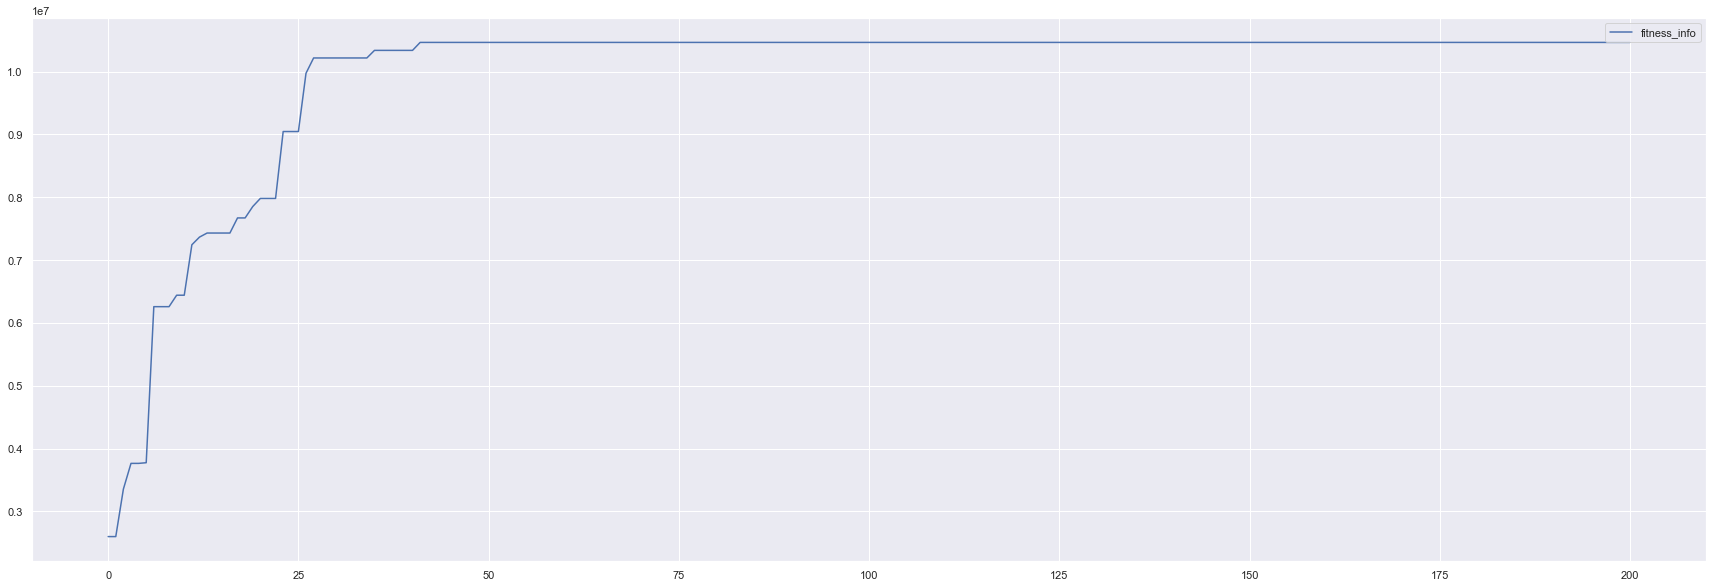

In [23]:
sns.lineplot(data=info_dict)
sns.set(rc={'figure.figsize':(50,10)})


In [21]:
# print out Global best fitness and solution
print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
print('Global best solution: {}'.format(best_dict['gbest_sol']))

Global best fitness: 10465290
Global best solution: [1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023]
